#### NX-414: Brain-like computation and intelligence
Notebook prepared by Alessandro Marin Vargas

# Week 8 - Mini projects (Predicting neural activity)

The objectives of the mini project are:
- Learn how to predict neural activity using linear regression from images and from neural network layers.
- Quantify the goodness of the model
- Compare the results across the network layers and between trained/random neural network
- Predict the neural activity using a neural network in a data-driven approach

Specifically, here you will use the data from the following [paper](https://www.jneurosci.org/content/jneuro/35/39/13402.full.pdf). The behavioral experiment consisted in showing to non-human primates some images while recording the neural activity with multielectrode arrays from the inferior temporal (IT) cortex. Here, the neural activity and the images are already pre-processed and you will have available the images and the corresponding average firing rate (between 70 and 170 ms) per each neuron.

In [25]:
import sys
import os
sys.path.append('./../')
# !{sys.executable} -m pip install gdown h5py

In [26]:
from week_6.utils import load_it_data, visualize_img
import matplotlib.pyplot as plt
import numpy as np
import gdown
# url = "https://drive.google.com/file/d/1s6caFNRpyR9m7ZM6XEv_e8mcXT3_PnHS/view?usp=share_link"
# output = "IT_data.h5"
# gdown.download(url, output, quiet=False, fuzzy=True)


### Load the data

In [32]:
path_to_data = '/Users/mverest/Documents/NX_414_Brain_Like_project/' ## Insert the folder where the data is, if you download in the same folder as this notebook then leave it blank

stimulus_train, stimulus_val, stimulus_test, objects_train, objects_val, objects_test, spikes_train, spikes_val = load_it_data(path_to_data)


In [ ]:
spikes_train.shape

(2592, 168)

# Challenge: Develop the most accurate model for predicting IT neural activity.

Throughout the mini-projects, you have acquired knowledge on predicting neural activity through both task-driven and data-driven approaches. You are now free to explore both approaches to create the most effective model for predicting neural activity. Here are some suggestions to help guide your exploration:
- Optimize your current models by adjusting hyperparameters and implementing different regularizations.
- Utilize different pretrained models.
- Employ a pretrained neural network and finetune it for predicting the neural activity.
- Train a neural network for object recognition while simultaneously predicting neural activity.
- ...

Please note that all models will be tested using the same type of linear regression.

### EVALUATION

You have until midnight of 07/05/25 to submit your mini-projects. Please upload a .zip file on Moodle containing your code and, specifically, the following:

- A one-page report (Report.pdf) detailing your investigation, including figures and model comparisons.
- A script (test.py) or notebook (test.ipynb) in which you show an example of your best model's usage. Please include instructions on loading the model and making neural predictions on the validation set. If necessary, include the checkpoint of your model in the .zip file.

Best of luck!

In [5]:
import torch
from torchvision.models import resnet50
from torchvision.models.feature_extraction import create_feature_extractor
from torch.utils.data import TensorDataset, DataLoader
from torchvision import transforms


In [6]:

device = "mps" if torch.backends.mps.is_available() else "cpu"
print("Using device:", device)

resnet = resnet50(pretrained=True)
resnet.eval()  # Mode évaluation


return_nodes = {
    'layer3': 'layer3',
    'layer4': 'layer4',
}
feature_extractor = create_feature_extractor(resnet, return_nodes=return_nodes).to(device)


# NORMALIZATION INVERSE FOUND IN utils.py
def inverse_normalisation(images):
    # Convert mean and std to NumPy arrays and reshape them for broadcasting
    normalize_mean = np.array([0.485, 0.456, 0.406]).reshape(1, 3, 1, 1)
    normalize_std = np.array([0.229, 0.224, 0.225]).reshape(1, 3, 1, 1)
    # Reverse the normalization transformation:
    # Multiply by std and add the mean, then scale to [0, 255]
    inv_images = (images * normalize_std + normalize_mean) * 255.0
    return inv_images.astype(np.uint8)

stimulus_train = inverse_normalisation(stimulus_train)
stimulus_val = inverse_normalisation(stimulus_val)

transform = transforms.Compose([
    transforms.ToTensor(),
    # Finally, apply the normalization with ImageNet statistics as used for ResNet50.
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


# CA SERT A RIEN ENFR PSK LES DATA ETAIENT DEJA DONNEE NORMALISEE COMME LE RESNET50 APAREMENT SURMENT DEJA FAIS PAR LES TA... MAIS BON COMME CA C'EST CLEAN NIVEAU PIPELINE

imgs_tensor = torch.stack([
    transform(np.transpose(img, (1, 2, 0)).astype(np.float32)/255.) 
    for img in stimulus_train])
dataset = TensorDataset(imgs_tensor)
loader = DataLoader(dataset, batch_size=8, shuffle=False)


imgs_val_tensor = torch.stack([
    transform(np.transpose(img, (1, 2, 0)).astype(np.float32)/255.) 
    for img in stimulus_val
])
val_dataset = TensorDataset(imgs_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)


Using device: mps


/opt/homebrew/Caskroom/miniconda/base/envs/nx_414/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/nx_414/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
activations_dct_train = {}
activations_dct_val = {}

for layer_name in  return_nodes.values() :
    print(f"\nProcessing layer: {layer_name}")
    activations_train = []
    with torch.no_grad():
        for batch in loader:
            imgs = batch[0].to(device)
            feats = feature_extractor(imgs)
            act = feats[layer_name].view(imgs.size(0), -1)
            activations_train.append(act.cpu().numpy())
    X_train = np.vstack(activations_train)

    activations_val = []
    
    with torch.no_grad():
        for batch in val_loader:
            imgs = batch[0].to(device)
            feats = feature_extractor(imgs)
            act = feats[layer_name].view(imgs.size(0), -1)
            activations_val.append(act.cpu().numpy())
    X_val = np.vstack(activations_val)
    activations_dct_train[layer_name] = X_train
    activations_dct_val[layer_name] = X_val


Processing layer: layer3

Processing layer: layer4


In [8]:
activations_dct_train['layer3'].shape, activations_dct_train['layer4'].shape

((2592, 200704), (2592, 100352))

In [ ]:
from sklearn.decomposition import PCA
import numpy as np

explained_variance_threshold = 0.95

pca_models_train = {}
pca_activations_train = {}
pca_activations_val = {}

for layer, X_train in activations_dct_train.items():
    pca_full = PCA().fit(X_train)
    cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)
    n_components = np.where(cumulative_variance >= explained_variance_threshold)[0][0] + 1
    print(f"For layer {layer}, retaining {n_components} components to achieve {explained_variance_threshold*100:.0f}% explained variance.")
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train)
    pca_activations_train[layer] = X_train_pca
    pca_models_train[layer] = pca
    X_val = activations_dct_val[layer]
    X_val_pca = pca.transform(X_val)
    pca_activations_val[layer] = X_val_pca
    print(f"Layer {layer} Done : {X_train_pca.shape} train, {X_val_pca.shape} val")



For layer layer3, retaining 2067 components to achieve 95% explained variance.
For layer layer4, retaining 1514 components to achieve 95% explained variance.


Using PCA: True, Layer: layer3, Dropout: True, Dropout Rate: 0.5, L2: True - 0.0001 Learning Rate: 5e-05, Hidden Dim: 1024, Epochs: 400
Epoch [1/400], Train Loss: 0.1872, Val Loss: 0.1423
Epoch [2/400], Train Loss: 0.1687, Val Loss: 0.1337
Epoch [3/400], Train Loss: 0.1542, Val Loss: 0.1262
Epoch [4/400], Train Loss: 0.1414, Val Loss: 0.1194
Epoch [5/400], Train Loss: 0.1299, Val Loss: 0.1130
Epoch [6/400], Train Loss: 0.1196, Val Loss: 0.1075
Epoch [7/400], Train Loss: 0.1106, Val Loss: 0.1028
Epoch [8/400], Train Loss: 0.1025, Val Loss: 0.0988
Epoch [9/400], Train Loss: 0.0956, Val Loss: 0.0956
Epoch [10/400], Train Loss: 0.0898, Val Loss: 0.0930
Epoch [11/400], Train Loss: 0.0846, Val Loss: 0.0907
Epoch [12/400], Train Loss: 0.0801, Val Loss: 0.0888
Epoch [13/400], Train Loss: 0.0757, Val Loss: 0.0872
Epoch [14/400], Train Loss: 0.0720, Val Loss: 0.0859
Epoch [15/400], Train Loss: 0.0689, Val Loss: 0.0848
Epoch [16/400], Train Loss: 0.0659, Val Loss: 0.0838
Epoch [17/400], Train Los

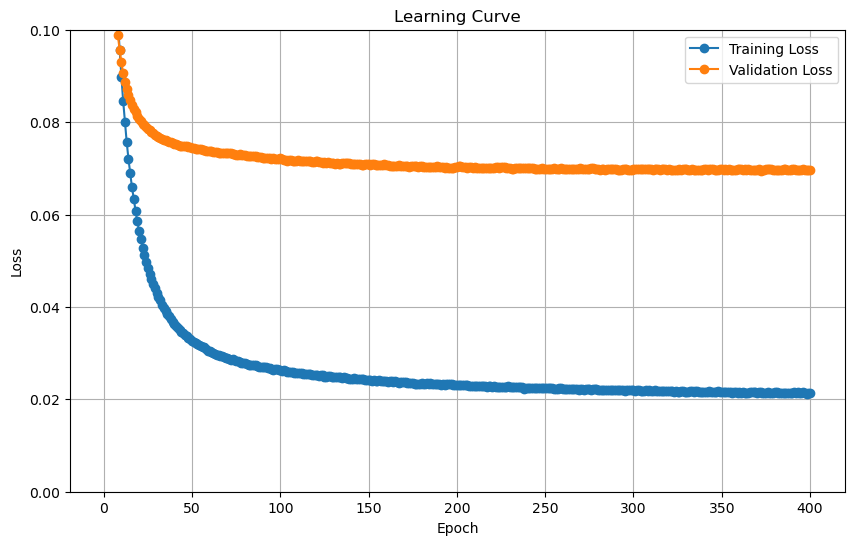

In [62]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np


device = "mps" if torch.backends.mps.is_available() else "cpu"


class TwoLayerFNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_prob=0.5, use_dropout=True):
        super(TwoLayerFNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.use_dropout = use_dropout
        if self.use_dropout:
            self.dropout = nn.Dropout(dropout_prob)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        if self.use_dropout:
            x = self.dropout(x)
        x = self.fc2(x)
        return x


use_dropout = True
droupout_prob = 0.5
layer_name = "layer3"  
pca = True
l2 = True
weight_decay = 1e-4
# lr = 0.0001
lr = 0.00005
hidden_dim = 1024
num_epochs = 400 

print(f"Using PCA: {pca}, Layer: {layer_name}, Dropout: {use_dropout}, Dropout Rate: {droupout_prob}, L2: {l2} - {weight_decay} Learning Rate: {lr}, Hidden Dim: {hidden_dim}, Epochs: {num_epochs}")


X_train = pca_activations_train[layer_name] if pca else activations_dct_train[layer_name]  
X_val   = pca_activations_val[layer_name] if pca else activations_dct_val[layer_name]
Y_train = spikes_train
Y_val   = spikes_val

input_dim = X_train.shape[1]


output_dim = spikes_train.shape[1]


model = TwoLayerFNN(input_dim, hidden_dim, output_dim, dropout_prob=droupout_prob, use_dropout=use_dropout).to(device)



X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32)  # Ensure Y_train is defined and correctly shaped

X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
Y_val_tensor = torch.tensor(Y_val, dtype=torch.float32)  # Ensure Y_val is defined and correctly shaped


# Create a TensorDataset and DataLoader for training.
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(X_val_tensor, Y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Use MSELoss for regression and an optimizer, e.g., Adam.
criterion = nn.MSELoss()

if l2 :
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay= weight_decay)
else :
    optimizer = optim.Adam(model.parameters(), lr=lr)
# Training loop for the two-layer FNN


train_loss = []
val_loss = []

for epoch in range(num_epochs):
    model.train()  
    running_train_loss = 0.0
    for batch_idx, (images, targets) in enumerate(train_loader):
        images = images.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()  
        outputs = model(images)  
        loss = criterion(outputs, targets)  
        loss.backward()         
        optimizer.step()        
        
        running_train_loss += loss.item()
    average_train_loss = running_train_loss / len(train_loader)
    train_loss.append(average_train_loss)  # Save the train loss for this epoch

    model.eval()  
    running_val_loss = 0.0
    with torch.no_grad():
        for images, targets in val_loader:
            images = images.to(device)
            targets = targets.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, targets)
            running_val_loss += loss.item()
    
    average_val_loss = running_val_loss / len(val_loader)
    val_loss.append(average_val_loss) 
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {average_train_loss:.4f}, Val Loss: {average_val_loss:.4f}")
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_loss, label='Training Loss', marker='o')
plt.plot(range(1, num_epochs + 1), val_loss, label='Validation Loss', marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.legend()
plt.grid(True)
plt.ylim(0, 0.1)
plt.show()



Explained Variance (FNN Model): 0.4376
Mean Pearson Correlation (FNN Model): 0.6536


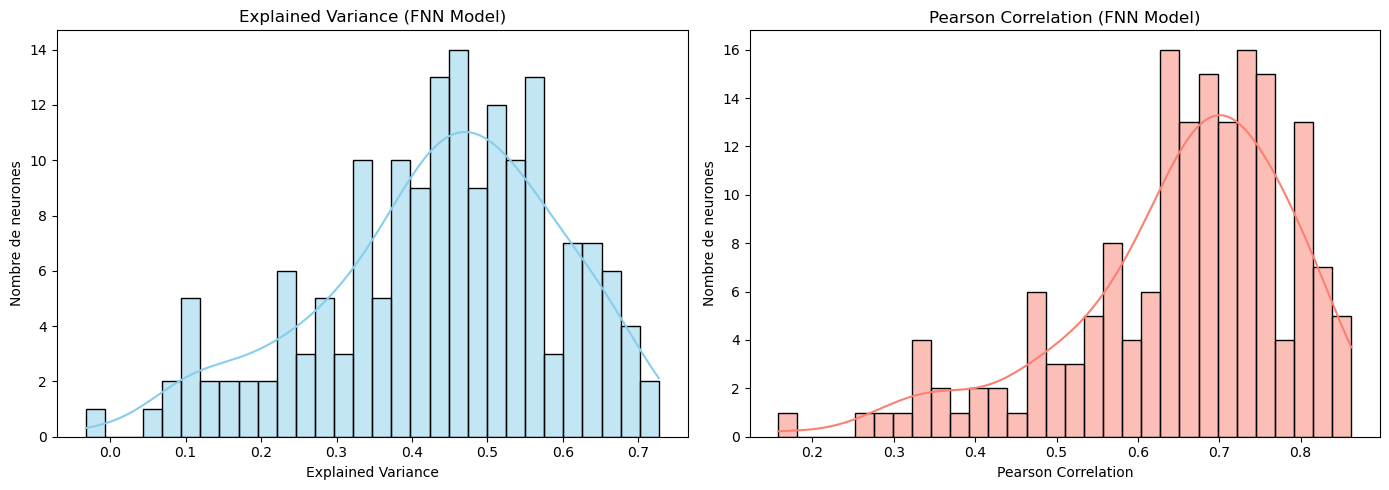

In [63]:
import torch
import numpy as np
from sklearn.metrics import explained_variance_score
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns

# Définition des fonctions d'évaluation :
def compute_pearson_per_neuron(Y_true, Y_pred):
    # Calcule la corrélation de Pearson pour chaque neurone (chaque colonne de Y)
    return np.array([
        pearsonr(Y_true[:, i], Y_pred[:, i])[0] for i in range(Y_true.shape[1])
    ])

def plot_performance_metrics(Y_pred, model_name, Y_val, verbose=True):
    # Calcule l'explained variance pour chaque neurone
    explained_var = explained_variance_score(Y_val, Y_pred, multioutput='raw_values')
    # Calcule la corrélation de Pearson par neurone
    corr_per_neuron = compute_pearson_per_neuron(Y_val, Y_pred)
    if verbose:
        print(f"Explained Variance ({model_name}): {explained_var.mean():.4f}")
        print(f"Mean Pearson Correlation ({model_name}): {corr_per_neuron.mean():.4f}")
    
    # Création des histogrammes pour visualiser la distribution des métriques
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    sns.histplot(explained_var, bins=30, kde=True, color="skyblue", ax=axes[0])
    axes[0].set_title(f"Explained Variance ({model_name})")
    axes[0].set_xlabel("Explained Variance")
    axes[0].set_ylabel("Nombre de neurones")

    sns.histplot(corr_per_neuron, bins=30, kde=True, color="salmon", ax=axes[1])
    axes[1].set_title(f"Pearson Correlation ({model_name})")
    axes[1].set_xlabel("Pearson Correlation")
    axes[1].set_ylabel("Nombre de neurones")
    
    plt.tight_layout()
    plt.show()

# Supposons que "model_fnn" soit votre modèle FNN déjà entraîné et que "val_loader" soit votre DataLoader pour l'ensemble de validation.
model.eval()  # On met le modèle en mode évaluation
all_predictions = []
all_targets = []

with torch.no_grad():
    for images, targets in val_loader:
        images = images.to(device)
        # Ici, on utilise model_fnn pour obtenir les prédictions
        outputs = model(images)
        all_predictions.append(outputs.cpu())
        all_targets.append(targets.cpu())

# On concatène les sorties de tous les batches pour obtenir des matrices complètes.
Y_pred = torch.cat(all_predictions, dim=0).numpy()
Y_val = torch.cat(all_targets, dim=0).numpy()

# Affichage des métriques de performance
plot_performance_metrics(Y_pred, "FNN Model", Y_val, verbose=True)




In [64]:
report = f"""
Model: TwoLayerFNN
----------------------------
Performance:
   - Final training loss: {train_loss[-1]:.4f}
   - Final validation loss: {val_loss[-1]:.4f}
   - Average Pearson correlation: {compute_pearson_per_neuron(Y_val, Y_pred).mean():.4f}
   - Average explained variance: {explained_variance_score(Y_val, Y_pred, multioutput='raw_values').mean():.4f}

Hyperparameters:
   - Learning Rate: {lr}
   - PCA Usage: {pca}
   - L2 Regularization: {l2}
   - Dropout Usage: {use_dropout}
   - Dropout Rate: {droupout_prob}
   - Layer used: {layer_name}
   - Input dimension: {input_dim}
   - Output dimension: {output_dim}
   - Hidden layer dimension: {hidden_dim}
   - Batch size: {batch_size}
   - Optimizer: Adam
   - Loss Function: MSELoss
   - Number of Epochs: {num_epochs}
"""

import os

report_path = "/Users/mverest/Documents/NX_414_Brain_Like_project/Week 8/perf/"
base_filename = "report.txt"
report_filename = base_filename
i = 1
while os.path.exists(os.path.join(report_path, report_filename)):
    report_filename = f"report{i}.txt"
    i += 1

report_filepath = os.path.join(report_path, report_filename)

with open(report_filepath, "w") as file:
    file.write(report)

print("report saved as", report_filepath)



report saved as /Users/mverest/Documents/NX_414_Brain_Like_project/Week 8/perf/report4.txt


Dans le cadre de votre projet, l'approche qui se rapproche le plus de ce qui se fait couramment dans la littérature en neurosciences computationnelles et en transfert learning consiste en plusieurs étapes intégrées :

1. Utiliser un grand modèle pré-entraîné (comme ResNet, VGG ou EfficientNet) pour extraire des représentations d'image à partir d'une couche profonde. Ces activations ont l'avantage d'être robustes et de capturer des caractéristiques de haut niveau souvent en corrélation avec les représentations observées dans le cortex IT.

2. Geler ces couches pré-entraînées afin de préserver les représentations acquises sur de grands jeux de données (par exemple ImageNet) et éviter le surapprentissage, surtout si le nombre d'exemples dans votre projet est limité.

3. Parallèlement, vous pouvez entraîner un petit CNN sur vos images afin d'extraire des représentations complémentaires spécifiques à votre jeu de données. Cette approche vous permet d'exploiter à la fois la puissance d'une représentation générale (du modèle pré-entraîné) et une représentation affinée pour la tâche de prédiction de l'activité neuronale.

4. Fusionner les deux représentations – par exemple en les concaténant – puis utiliser un réseau entièrement connecté (FNN) pour effectuer la prédiction finale de l’activité neuronale. Cette étape de fusion permet d'intégrer de manière non linéaire les informations issues des deux sources.

Ce pipeline est une variante des approches classiques qui consistent généralement à extraire des features via un réseau pré-entraîné et à appliquer ensuite une régression linéaire pour prédire les réponses neuronales. En introduisant un module CNN complémentaire, vous apportez une touche innovante tout en vous inscrivant dans une logique de transfert learning efficace. Ce type d'architecture hybride répond à la fois à des critères de robustesse (grâce aux features issues d’un grand modèle pré-entraîné) et de spécificité (via l’apprentissage sur mesure des représentations par votre petit CNN), ce qui est en adéquation avec les pratiques actuelles dans le domaine.

En résumé, cette approche – utiliser un modèle pré-entraîné pour l’extraction de features, geler ses poids, parallèlement entraîner un petit CNN spécifique, concaténer les représentations, puis utiliser un FNN pour la prédiction – est cohérente avec ce que fait la communauté dans des projets similaires de prédiction d’activité neuronale, tout en apportant une innovation intéressante par la fusion de représentations complémentaires.

## Approche plus Classique : 

Suivre une approche classique reviendrait essentiellement à exploiter les représentations issues d’un modèle pré-entraîné comme extracteur de features, puis de les utiliser pour apprendre une correspondance linéaire avec l’activité neuronale. Voici les grandes étapes d’une approche classique :

1. Extraction des features  
   - Vous passez vos images à travers un grand modèle pré-entraîné (par exemple, VGG, ResNet ou EfficientNet) et extrayez les activations d’une couche profonde. Ces représentations de haut niveau sont souvent en corrélation avec les caractéristiques de la réponse dans le cortex IT, comme illustré dans la littérature (cf. Majaj et al., 2015 citeturn0file0).

2. Construction de la réponse matricielle  
   - Organisez les activations en une matrice où chaque ligne correspond à une image et chaque colonne à une feature. Cette matrice servira de base pour prédire la réponse de vos neurones.
   - Parallèlement, organisez les taux de décharge moyens (entre 70 et 170 ms) de chaque neurone en vecteurs cibles correspondants aux images.

3. Apprentissage d’un décodage linéaire  
   - Utilisez des techniques classiques comme la régression linéaire (avec éventuellement une régularisation de type Ridge ou Lasso) ou un SVM linéaire pour établir la relation entre les features extraites et l’activité neuronale.
   - L’idée est de trouver une combinaison linéaire de features qui reproduise au mieux les taux de décharge observés (la méthode dite « LaWS of RAD IT » dans la littérature).

4. Validation et évaluation  
   - Effectuez un découpage des données en ensembles d’entraînement et de test, et potentiellement une validation croisée, afin de s’assurer que le modèle généralise bien sur des données non vues.
   - Mesurez la performance à l’aide de métriques adaptées telles que le coefficient de corrélation (Pearson, Spearman) ou encore le R².

Cette approche classique – extraire des features robustes d’un réseau pré-entraîné puis utiliser une régression linéaire pour prédire l’activité neuronale – est largement utilisée dans les travaux de neuroscience computationnelle, car elle permet de capitaliser sur la qualité des représentations apprises sur de grands jeux de données tout en offrant une méthode d’interprétation simple et reproductible.